# Deep Learning - Image Classification for Ages

The goal of this project is to build a deep learning model that will predict ages when given images of people.

For both humans and machine, predicting an exact age can be extremely difficult but predicting an age range is much easier. Therefore I created 12 different unequal age brackets for our machine to train on and predict.

My approach to this project was to follow the OSEMN framework. The steps of this framework is as follow -

  1. Obtain the data
  2. Scrub the data
  3. Explore the data
  4. Model the data
  5. iNterpret the data


## Obtain the Data
The data that I am working with is from Kaggel which can be gotten from this [link](https://www.kaggle.com/jangedoo/utkface-new). It include around 23,000 images of cropped human faces of various ages, gender and ethnicity. The images also cover a large variation in pose, facial expression, illumination, occlusion, resolution, etc.

Since using all the images might be overwhelming for my pc, and also create a class unbalance, I decided to only use around 1000 images for each class.

First I will need to setup the folders and import all the necessary libraries and files.

# New Section

In [ ]:
from google.colab import  drive
drive.mount('/drive')



Mounted at /drive


In [ ]:
# Check to see if tensorflow detect a gpu
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
%matplotlib inline 
import random
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
import seaborn as sns
from keras import layers
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
import datetime
from PIL import Image
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator


The code below is used to read all of the dataset and create a pandas dataframe with the unique file names used as id. The lables for age and gender are included in the file names so I extracted those informations and added it to the data frame.

In [ ]:
## Code used to create a dataframe using the file name as id with age and gender labels

# df = pd.DataFrame(columns = ['id', 'age', 'gender'])

# fldr = "data\\UTKFace"
# files=os.listdir(fldr)


# for fle in files:
#   age=int(fle.split('_')[0])
#   gender=int(fle.split('_')[1])
#   id = fle
#   df = df.append({'id': id, 'age': age, 'gender': gender}, ignore_index=True)

# For google colab.
df = pd.read_csv('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/age_gender_df.csv')

## For jupyter notebook
# df = pd.read_csv('age_gender_df.csv')
display(df.head())
print("\n")
df.info()

,Unnamed: 0,id,age,gender
0,0,80_1_0_20170120221022764.jpg.chip.jpg,80,1
1,1,80_1_0_20170110183156137.jpg.chip.jpg,80,1
2,2,80_1_0_20170110141320400.jpg.chip.jpg,80,1
3,3,80_0_1_20170111181750520.jpg.chip.jpg,80,0
4,4,80_1_0_20170110154556609.jpg.chip.jpg,80,1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  23708 non-null  int64 
 1   id          23708 non-null  object
 2   age         23708 non-null  int64 
 3   gender      23708 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 741.0+ KB


Below are the 12 diffrent age bins that I created for this project. As you can see the age bins are not equal. I used age ranges where people look similar.

In [ ]:
#Create Age Bins
age_bins = [[1, 3], [4, 10], [11, 17], [18, 22], [23, 26], [27, 32], [33, 37], [38, 45], [46, 53], [54, 62], [63, 73] \
            , [74, 120]]

In [ ]:
# Read in the dataframes containing information about the images
train_df = pd.read_csv("/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/train_df.csv", index_col=0)
test_df = pd.read_csv("/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/test_df.csv", index_col=0)
train_df.head()

,id,age,gender,BIN
0,1_0_0_20170110213517302.jpg.chip.jpg,1,0,"[1, 3]"
1,1_0_0_20170110213138878.jpg.chip.jpg,1,0,"[1, 3]"
2,1_0_0_20170110212745529.jpg.chip.jpg,1,0,"[1, 3]"
3,1_0_0_20170110212623527.jpg.chip.jpg,1,0,"[1, 3]"
4,1_0_0_20170110212603790.jpg.chip.jpg,1,0,"[1, 3]"


Since the raw data contain over 20,000 image, it would be too much for my pc to handle. Therefore I decided to put a maximun of 1000 images for each bins, and set the bins so that an equal I have an equal amount of images in each.

Below is the code I used to set up the directories, folders and images so that keras can easily read them.

In [ ]:
new_root_dir = 'data/'
old_dir = 'data/UTKFace/'

# os.mkdir(new_root_dir) 

dir_names = ['train', 'val', 'test']

## New directories are made for train, val and test

# for d in dir_names:
#     new_dir = os.path.join(new_root_dir, d)
#     os.mkdir(new_dir)
## Creating folders for bins and diffrent types

# for bin_ in age_bins:
#     print('Moving Age Bins {} pictures.'.format(bin_))
#     # Create sub_directories
#     for d in dir_names:
#         new_dir = os.path.join(new_root_dir, d, str(bin_))
#         os.mkdir(new_dir)
#     # Subset dataframe into train, validate and split sets
#     temp = df[(df.age >= bin_[0]) & (df.age <= bin_[1])]
    
#     if len(temp) >= 1000:
#         temp2 = temp.sample(n = 1000)
#     else:
#         temp2 = temp.sample(len(temp))

#     train, validate, test = np.split(temp2, [int(.8*len(temp2)), int(.9*len(temp2))])
#     print('Split {} imgs into {} train, {} val, and {} test examples.'.format(len(temp),
#                                                                               len(train),
#                                                                               len(validate),
#                                                                               len(test)))
#     for i, temp in enumerate([train, validate, test]):
#         for row in temp.index:
#             filename = temp['id'][row]
#             origin = os.path.join(old_dir + filename)
#             destination = os.path.join(new_root_dir + dir_names[i] + '/' + str(bin_) + '/' + filename)
#             shutil.copy(origin, destination)


### Scrubbing the Data

After I have split the images with the method above, preparing the images for Keras is very easy using the ImageDataGenerator.

Since the images are in colour, they include RGB values that have to be scaled which I did using the (rescale=1./255) parameter. The target size I chose is (224, 224) which is the size most model that I will use for transfer learning requires.

ImageDataGenerator also create one hot encoding classes for for me.

I could have also use ImageDataGenerator to augment the images if I wanted more images for training.

In [ ]:
# Set the directory paths

train_dir = "/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/data/train"
validation_dir = "/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/data/val"
test_dir = "/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/data/test"

## Scale by 1/255 and shape the images to (224, 224) which is the most common shape used by the Models I will be using for transfer learning
train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_dir, target_size=(224,224), batch_size=(192), class_mode='categorical')
valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=validation_dir, target_size=(224,224), batch_size=(80), class_mode='categorical')

## Set the shuffle = False to make sure the models can be evaluated
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_dir, target_size=(224,224), batch_size=(1200), class_mode='categorical', shuffle=False)
test_images, test_labels = next(test_batches)

# Create the label map
label_map = (test_batches.class_indices)

Found 9600 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.


In [ ]:
# Read in the csv file that I created including all the model scores
model_scores = pd.read_csv("/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/model_scores.csv")
# model_scores = pd.DataFrame(columns = ['Model Name', 'Training Loss', 'Training Accuracy', 'Testing Loss', 'Testing Accuracy'])

In [ ]:
# Make sure everything is correct
assert train_batches.n == 9600
assert valid_batches.n == 1200
assert test_batches.n == 1200
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 12

In [ ]:
# Creating an empty dictionary
label_maps_rev = {}

# Using the for loop to insert indexes and age bins in the dictionary
for i, v in enumerate(list(label_map.keys())):
    label_maps_rev.update({i : v})

label_maps_rev

{0: '[01, 03]',
 1: '[04, 10]',
 2: '[11, 17]',
 3: '[18, 22]',
 4: '[23, 26]',
 5: '[27, 32]',
 6: '[33, 37]',
 7: '[38, 45]',
 8: '[46, 53]',
 9: '[54, 62]',
 10: '[63, 73]',
 11: '[74, 120]'}

### Explore the data

Next I took a look at the images and saw that they are all cropped and scaled. They are ready to be trained on.

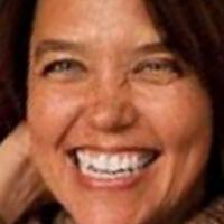

Real Age Bracket :  [46, 53]


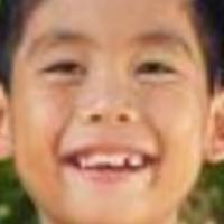

Real Age Bracket :  [04, 10]


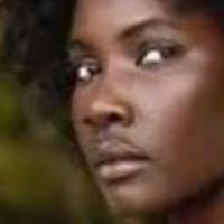

Real Age Bracket :  [23, 26]


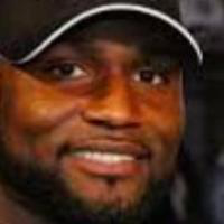

Real Age Bracket :  [27, 32]


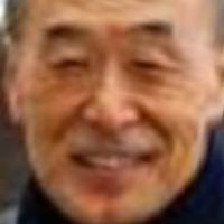

Real Age Bracket :  [54, 62]


In [ ]:
train_images, train_labels = next(train_batches)

# Check What the images looks like
for i in range(0,5):
  rand_num = random.randint(0, 191)
  display(array_to_img(train_images[rand_num]))
  print("Real Age Bracket : ", label_maps_rev[train_labels[rand_num].argmax()])


The value count for the younger ages are much larger than the older ages but this is to expected because of the bins I set. If we look at the bin count, we can see that all the classes have the same amount of images.

Text(0, 0.5, 'Count')

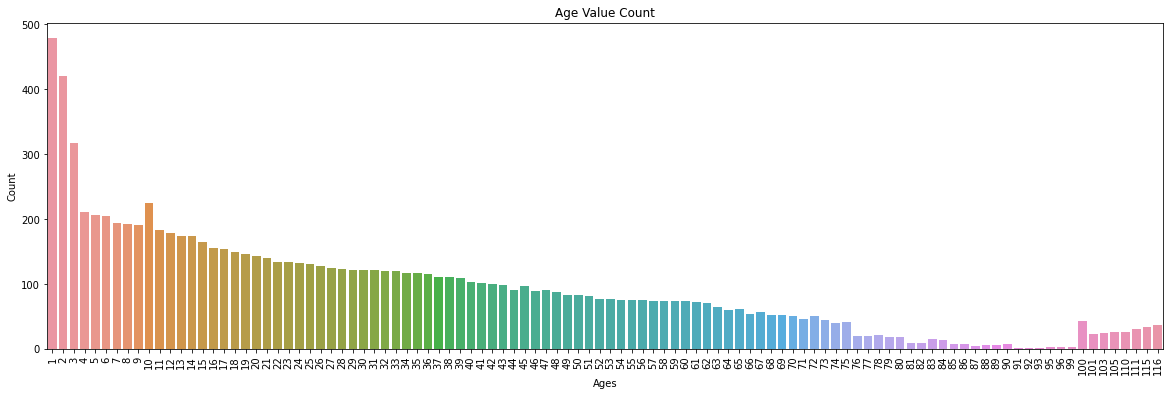

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(x=train_df['age'].unique(),y=train_df['age'].value_counts())
ax.set_title("Age Value Count")
plt.xticks(rotation=90)
ax.set_xlabel("Ages")
ax.set_ylabel("Count")

[1, 3]       800
[27, 32]     800
[38, 45]     800
[54, 62]     800
[23, 26]     800
[46, 53]     800
[18, 22]     800
[11, 17]     800
[33, 37]     800
[74, 120]    800
[63, 73]     800
[4, 10]      800
Name: BIN, dtype: int64


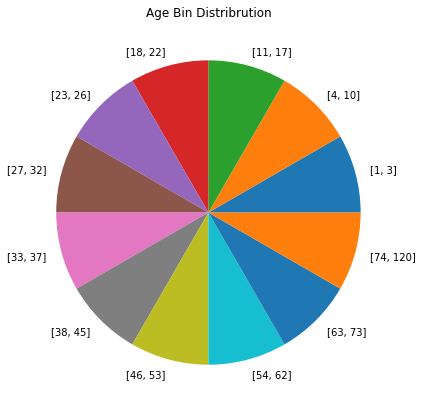

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(10,7))

ax.pie(train_df.groupby("BIN").count()['age'], labels=age_bins);
ax.set_title('Age Bin Distribrution')
plt.plot()

print(train_df["BIN"].value_counts())

Before I start building the models, I will create three diffrent fuctions that will help keep track and plot the data better.

The first function will plot the model loss and accuracy. The second will update the dataframe keeping track of the model metrics. The third will plot a confusion matrix heatmap to make sense of how the model is performing.

In [ ]:
# Function to plot model loss and accuracy
def visualize_scores(model_histoy, model_name):

  fig, axs = plt.subplots(2, 1, figsize=(10,10), sharex=True)

  acc = model_histoy.history['acc']
  val_acc = model_histoy.history['val_acc']
  loss = model_histoy.history['loss']
  val_loss = model_histoy.history['val_loss']
  epochs = range(len(acc))
  axs[0].plot(epochs, acc, color= 'g', label='Training acc')
  axs[0].plot(epochs, val_acc, 'r', label='Validation acc')
  axs[0].set_title(model_name + ' Accuracy')
  axs[0].legend()

  axs[1].plot(epochs, loss, 'g', label='Training loss')
  axs[1].plot(epochs, val_loss, 'r', label='Validation loss')
  axs[1].set_title(model_name + ' Loss')
  plt.xlabel('Epochs')
  axs[1].legend()
  fig.show()

In [ ]:
# Function to update dataframe containing the metrics. test_images and test_labels can be changed if there is a need
def update_scores_df(model, model_hist, model_name, df=model_scores, test_img = test_images, test_lab = test_labels):

    acc = model_hist.history['acc']
    val_acc = model_hist.history['val_acc']
    loss = model_hist.history['loss']
    val_loss = model_hist.history['val_loss']

    test_scores = model.evaluate(test_img, test_lab)

    return model_scores.append({'Model Name': model_name, 'Training Loss': min(loss), 'Training Accuracy': max(acc), 'Testing Loss': test_scores[0], 'Testing Accuracy': test_scores[1]}, ignore_index=True)


In [ ]:
# Function to create a confusion matrix to take a closer look at model performance.
def plot_matrix(model, model_name, test_label= test_labels, test_img=test_images):
    model_preds = model.predict(test_img)
    model_pred_ind = model_preds.argmax(axis=1)

    test_label_indices = test_label.argmax(axis=1)


    fig, axs = plt.subplots(figsize=(8,7))
    results = confusion_matrix(test_label_indices, model_pred_ind)
    sns.heatmap(results, annot=True, xticklabels= age_bins, yticklabels= age_bins, cmap="rocket_r")

    axs.set_title(model_name + ' Confusion Matrix Heat Map')
    axs.set_xlabel("Predicted Age")
    axs.set_ylabel("True Age")

# Baseline CNN (Convolutional Neural Network)

The first model that I will build is a Convolution Neural Network. CNN models excels at working with image and video so it is perfect for our task.

This models includes 4 hidden layers that use reLu activation with an ouput layer that uses softmax activation.

In [ ]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224 ,224,  3)))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(32, (4, 4), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(12, activation='softmax'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 108, 108, 32)      16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)            

In [ ]:
# Compile the model
model1.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

# Train the model
model1_hist = model1.fit(x= train_batches,
            epochs=50,
            validation_data= valid_batches,
            verbose=2
            )


Epoch 1/50
32/32 - 1763s - loss: 2.4795 - acc: 0.1080 - val_loss: 2.4716 - val_acc: 0.1217
Epoch 2/50
32/32 - 25s - loss: 2.4657 - acc: 0.1351 - val_loss: 2.4583 - val_acc: 0.1033
Epoch 3/50
32/32 - 25s - loss: 2.4457 - acc: 0.1354 - val_loss: 2.4286 - val_acc: 0.1317
Epoch 4/50
32/32 - 25s - loss: 2.4200 - acc: 0.1456 - val_loss: 2.3927 - val_acc: 0.1375
Epoch 5/50
32/32 - 24s - loss: 2.3960 - acc: 0.1519 - val_loss: 2.3535 - val_acc: 0.1775
Epoch 6/50
32/32 - 25s - loss: 2.3647 - acc: 0.1726 - val_loss: 2.4411 - val_acc: 0.1225
Epoch 7/50
32/32 - 25s - loss: 2.3433 - acc: 0.1782 - val_loss: 2.3285 - val_acc: 0.2000
Epoch 8/50
32/32 - 25s - loss: 2.3126 - acc: 0.1818 - val_loss: 2.2982 - val_acc: 0.1942
Epoch 9/50
32/32 - 24s - loss: 2.2848 - acc: 0.1981 - val_loss: 2.2495 - val_acc: 0.2192
Epoch 10/50
32/32 - 26s - loss: 2.2310 - acc: 0.2182 - val_loss: 2.3576 - val_acc: 0.1517
Epoch 11/50
32/32 - 24s - loss: 2.2203 - acc: 0.2164 - val_loss: 2.1844 - val_acc: 0.2283
Epoch 12/50
32/32

In [ ]:
## Save the model
# model1.save('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model1')

## Load the model
model1 = keras.models.load_model('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model1')

INFO:tensorflow:Assets written to: /drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model1/assets


38/38 [==============================] - 1s 20ms/step - loss: 1.7893 - acc: 0.3333


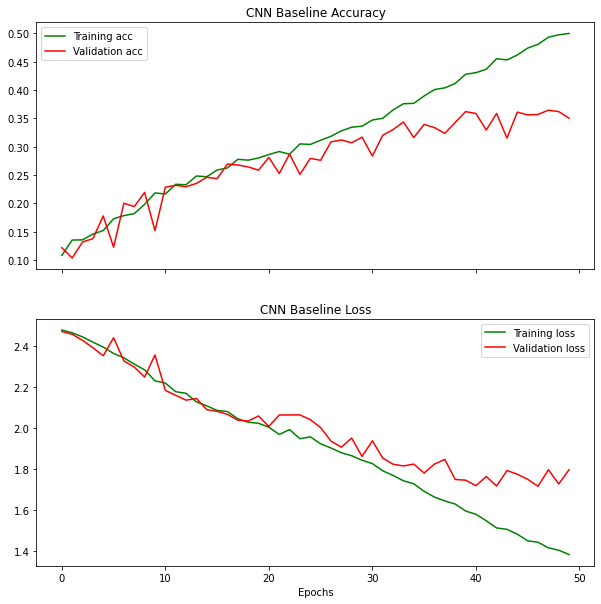

In [ ]:
visualize_scores(model1_hist, 'CNN Baseline')

## Update the model scores
model_scores = update_scores_df(model1, model1_hist, 'CNN Baseline')


We can see that the scores for the training data is still steadily improving but the scores for the validation data has started to plateau. If we continue the training it would just cause more overfitting.

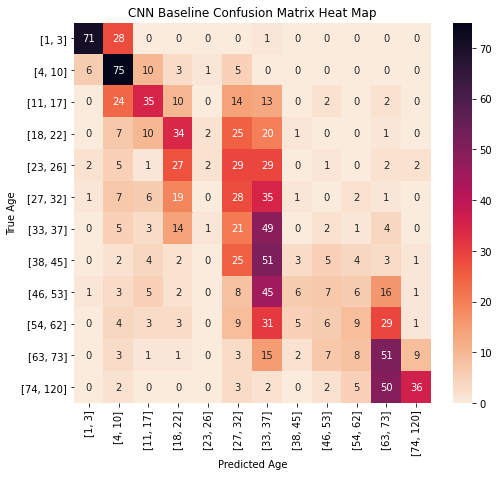

In [ ]:
plot_matrix(model1, 'CNN Baseline')


In [ ]:
model_scores

,Model Name,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,CNN Baseline,1.383092,0.499583,1.789274,0.333333


The CNN Baseline model achieve 0.33 accuracy on the test data compared to the th 0.50 on the training data. Showing that there is slight overfitting.

Looking at the confusion heatmap matrix, the model performs decently. You can see that alot of the false predictions are still within reasonable range. The model have a lot of trouble for the bins in the middle.

# Transfer Learning

Since our model was trained only using the 11,200 images that we provided, it is not that sophisticated. To improve the predictions, I will make use of transfer learning.

In real-world applications, building a good image classification model can take days of training and millions of images to achieve high performance. It is easier for us to use a pretrained model and retrain it on our own dataset. This is called Transfer Learning.

All of the models that I will be using are trained on imagenet dataset which contains 14 million images and 1000 clasess. This is much bigger than our dataset.

Since early layers of images classification are use to detect simple details that are in all images such as edges, blobs of colors, and vague patterns, it can be transfer to our model.


# VGG19

The first pre-trained models that I will use is VGG19. VGG19 is a convolutional neural network that is used for large scale image classification designed by K. Simonyan and A. Zisserman from the University of Oxford.


In [ ]:
# Initialize Base
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

# Define Model Architecture
model2 = models.Sequential()
model2.add(cnn_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(12, activation='softmax'))

# Freeze the base models so that pre-training isn't deleted
cnn_base.trainable = False
model2.layers[0].trainable = False

model2.build(input_shape=(None, 224,224, 3))

# Chec whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model2.layers:
    print(layer.name, layer.trainable)

print("\n")

# Check how many trainable weights are in the model 
print(len(model2.trainable_weights))

print("\n")

model2.summary()

80142336/80134624 [==============================] - 1s 0us/step
module_wrapper False
flatten_2 True
dense_4 True
dense_5 True
dense_6 True
dense_7 True
dense_8 True


10


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dens

In [ ]:
# Double check if the layers are frozen in the basemodel
for layer in cnn_base.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [ ]:
checkpoint_path = "/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/TransferLearning_model1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpointer = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
# Early_stop=tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer] #,Early_stop

In [ ]:
# Compile the Model
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

# Train the Model
model2_hist = model2.fit(train_batches,
                              epochs=50,
                              validation_data=valid_batches,
                              verbose=2
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
32/32 - 105s - loss: 2.4694 - acc: 0.1059 - val_loss: 2.4381 - val_acc: 0.1300
Epoch 2/50
32/32 - 56s - loss: 2.3909 - acc: 0.1905 - val_loss: 2.3380 - val_acc: 0.2317
Epoch 3/50
32/32 - 56s - loss: 2.2735 - acc: 0.2464 - val_loss: 2.2176 - val_acc: 0.2675
Epoch 4/50
32/32 - 57s - loss: 2.1498 - acc: 0.2804 - val_loss: 2.1050 - val_acc: 0.2908
Epoch 5/50
32/32 - 56s - loss: 2.0382 - acc: 0.3052 - val_loss: 2.0156 - val_acc: 0.3067
Epoch 6/50
32/32 - 56s - loss: 1.9507 - acc: 0.3227 - val_loss: 1.9403 - val_acc: 0.3250
Epoch 7/50
32/32 - 56s - loss: 1.8805 - acc: 0.3414 - val_loss: 1.8869 - val_acc: 0.3233
Epoch 8/50
32/32 - 56s - loss: 1.8301 - acc: 0.3493 - val_loss: 1.8432 - val_acc: 0.3433
Epoch 9/50
32/32 - 56s - loss: 1.7809 - acc: 0.3656 - val_loss: 1.8092 - val_acc: 0.3342
Epoch 10/50
32/32 - 56s - loss: 1.7429 - acc: 0.3781 - val_loss: 1.7785 - val_acc: 0.3525
Epoch 11/50
32/32 - 56s - loss: 1.7096 - acc: 0.3835 - val_loss: 1.7533 - val_acc: 0.3558
Epoch 12/50
32/32 

In [ ]:
#Save the Model
# model2.save('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model2')
model2 = keras.models.load_model('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model2')



INFO:tensorflow:Assets written to: /drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model2/assets


38/38 [==============================] - 16s 251ms/step - loss: 1.5910 - acc: 0.3708


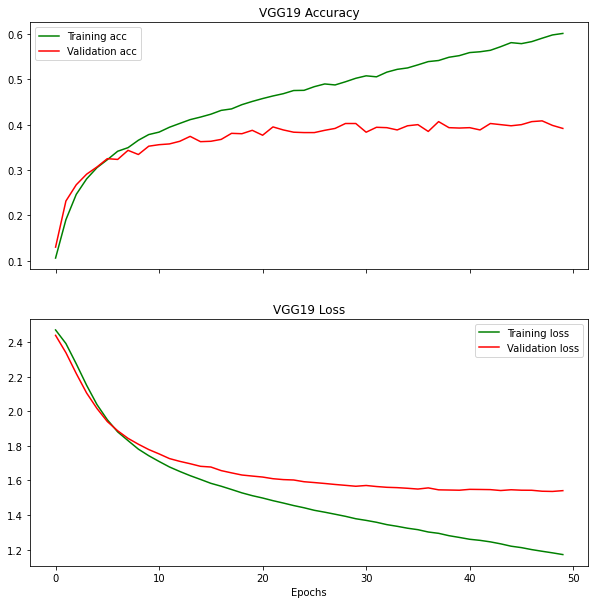

In [ ]:
visualize_scores(model2_hist, 'VGG19')
# model_scores = update_scores_df(model2, model2_hist, 'VGG19 Baseline')

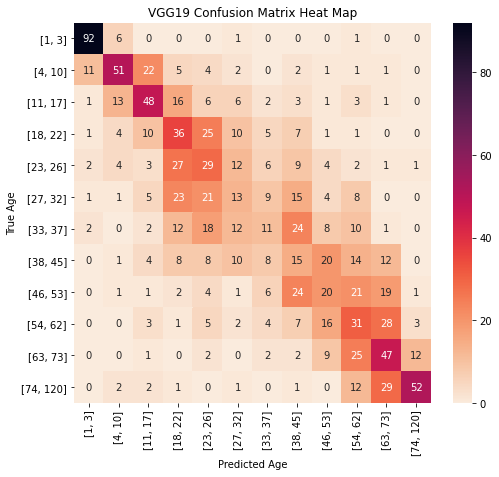

In [ ]:
plot_matrix(model2, 'VGG19')

There is a discrepancy between the training data and validation data for both loss and accuracy. This is a sign of overfitting, therefore I will add a dropout layer with a rate of 0.5 to my next model. Looking at the confusion matrix, an improvement from the previous model is obvious especially in the middle.

The accuracy for the test data around 0.04 percent better and is not bad.

It also looks like both the loss and accuracy are still improving steadily. It might be a good idea to train longer after I have settle on a final model.

# VGG19 16-Layers with Dropout (0.5)

This time I will try leaving the last block in VGG19 trainable and also add a Dropout layer with a rate of 0.5. Dropout is a regularization method that leave a specified amount of nodes off during each epochs to reduce overfitting.

In [ ]:
# Initialize Base
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))


# Define Model Architecture
model3 = models.Sequential()
model3.add(cnn_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))

model3.add(layers.Dense(12, activation='softmax'))

# Freeze only some of the layers
for layer in cnn_base.layers[0:17]:
    layer.trainable = False

model3.build(input_shape=(None, 224, 224, 3))

# Check the layers
for layer in model3.layers:
    print(layer.name, layer.trainable)

print("\n")

for layer in cnn_base.layers:
    print(layer.name, layer.trainable)

print("\n")

# Print Model Summary
model3.summary()

module_wrapper_1 True
flatten_3 True
dense_9 True
dense_10 True
dense_11 True
dense_12 True
dropout True
dense_13 True


input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_1 (ModuleWrap (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1

In [ ]:
# Compile the model
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

# Training the Model
model3_hist = model3.fit(train_batches,
                              epochs=50,
                              validation_data=valid_batches,
                              verbose=2
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
32/32 - 67s - loss: 2.4595 - acc: 0.1194 - val_loss: 2.3925 - val_acc: 0.1992
Epoch 2/50
32/32 - 63s - loss: 2.3026 - acc: 0.1986 - val_loss: 2.0478 - val_acc: 0.2900
Epoch 3/50
32/32 - 62s - loss: 2.0611 - acc: 0.2734 - val_loss: 1.8443 - val_acc: 0.3325
Epoch 4/50
32/32 - 62s - loss: 1.8825 - acc: 0.3197 - val_loss: 1.7173 - val_acc: 0.3667
Epoch 5/50
32/32 - 63s - loss: 1.7749 - acc: 0.3486 - val_loss: 1.6440 - val_acc: 0.3800
Epoch 6/50
32/32 - 63s - loss: 1.6733 - acc: 0.3747 - val_loss: 1.5697 - val_acc: 0.3950
Epoch 7/50
32/32 - 63s - loss: 1.6046 - acc: 0.3924 - val_loss: 1.5516 - val_acc: 0.3917
Epoch 8/50
32/32 - 63s - loss: 1.5290 - acc: 0.4130 - val_loss: 1.5084 - val_acc: 0.4083
Epoch 9/50
32/32 - 63s - loss: 1.4650 - acc: 0.4353 - val_loss: 1.4882 - val_acc: 0.4067
Epoch 10/50
32/32 - 63s - loss: 1.4027 - acc: 0.4519 - val_loss: 1.4697 - val_acc: 0.4075
Epoch 11/50
32/32 - 63s - loss: 1.3425 - acc: 0.4858 - val_loss: 1.4825 - val_acc: 0.4067
Epoch 12/50
32/32 -

In [ ]:
# # Save the model
model3.save('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model_3')
# model3 = keras.models.load_model('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model_3')


INFO:tensorflow:Assets written to: /drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model_3/assets


38/38 [==============================] - 6s 143ms/step - loss: 2.7200 - acc: 0.4083


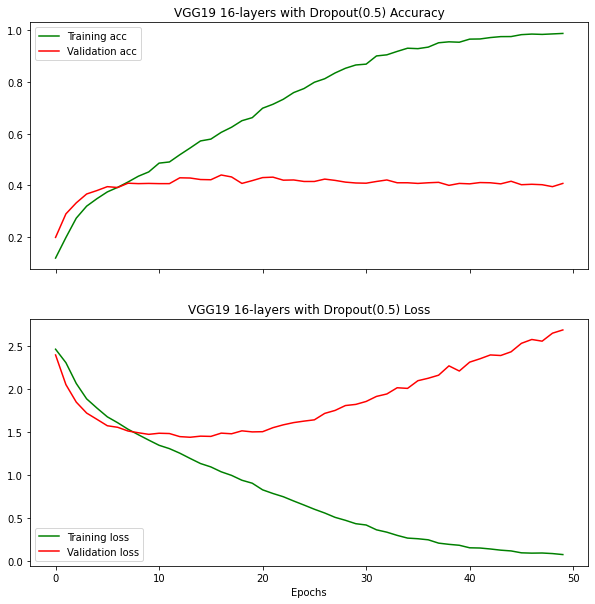

In [ ]:
# Plot model scores
visualize_scores(model3_hist, 'VGG19 16-layers with Dropout(0.5)')
# model_scores = update_scores_df(model3, model3_hist, 'VGG19 16-layers with Dropout(0.5)')

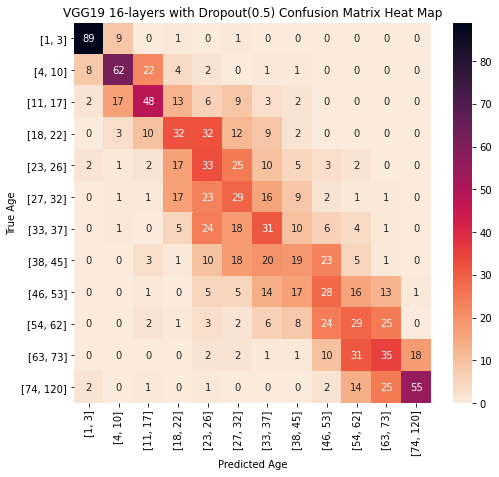

In [ ]:
plot_matrix(model3, "VGG19 16-layers with Dropout(0.5)")

In [ ]:
# model_scores.to_csv("/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/model_scores.csv")
model_scores

,Unnamed: 0,Model Name,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,0,CNN Baseline,1.383092,0.499583,1.789274,0.333333
1,1,VGG19 Baseline,1.171834,0.601042,1.590957,0.370833
2,2,VGG19 16-layers with Dropout(0.5),0.072023,0.986458,2.720024,0.408333
3,3,VGG19 16-layers with Regularization,2.052804,0.986979,4.529291,0.390833
4,4,VGG16,1.730817,0.535208,1.970884,0.446667
5,5,ResNet50 Layers with l2 Regularization,1.410144,0.994792,4.178020,0.351667
6,6,EfficientNet,0.066275,0.977500,5.137754,0.387500


The model accuracy for the training data improve massively to 0.99 but the accuracy for the test is only around 0.40, showing a massive overfitting problem. It might be interesting to try other methods of regularization and decreasing the number of layers.

# VGG19 Heavy Regulariazation
Since there seems to be signs of overfitting,  I will now add heavier regularization to see if it will improve the model.

In [ ]:
# Initialize Base
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))


# Define Model Architecture
model4 = models.Sequential()
model4.add(cnn_base)
model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model4.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model4.add(layers.Dropout(0.5))

model4.add(layers.Dense(12, activation='softmax'))

# Freeze only some of the layers
for layer in cnn_base.layers[0:17]:
    layer.trainable = False

model4.build(input_shape=(None, 224, 224, 3))

# Check the layers
for layer in model4.layers:
    print(layer.name, layer.trainable)

print("\n")

for layer in cnn_base.layers:
    print(layer.name, layer.trainable)

print("\n")

# Print Model Summary
model4.summary()

80142336/80134624 [==============================] - 1s 0us/step
module_wrapper True
flatten True
dense True
dense_1 True
dropout True
dense_2 True


input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                

In [ ]:
# Compile the model
model4.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

# Training the Model
model4_hist = model4.fit(train_batches,
                              epochs=50,
                              validation_data=valid_batches,
                              verbose=2
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
32/32 - 2254s - loss: 6.5509 - acc: 0.1553 - val_loss: 6.2211 - val_acc: 0.2542
Epoch 2/50
32/32 - 66s - loss: 6.0487 - acc: 0.2499 - val_loss: 5.7582 - val_acc: 0.3267
Epoch 3/50
32/32 - 65s - loss: 5.6766 - acc: 0.3085 - val_loss: 5.4506 - val_acc: 0.3492
Epoch 4/50
32/32 - 65s - loss: 5.3910 - acc: 0.3542 - val_loss: 5.2524 - val_acc: 0.3608
Epoch 5/50
32/32 - 65s - loss: 5.1638 - acc: 0.3904 - val_loss: 5.0581 - val_acc: 0.3833
Epoch 6/50
32/32 - 65s - loss: 4.9714 - acc: 0.4117 - val_loss: 4.9046 - val_acc: 0.4017
Epoch 7/50
32/32 - 65s - loss: 4.7977 - acc: 0.4363 - val_loss: 4.7948 - val_acc: 0.3942
Epoch 8/50
32/32 - 65s - loss: 4.6650 - acc: 0.4544 - val_loss: 4.7072 - val_acc: 0.3942
Epoch 9/50
32/32 - 65s - loss: 4.5246 - acc: 0.4787 - val_loss: 4.6477 - val_acc: 0.3892
Epoch 10/50
32/32 - 65s - loss: 4.3764 - acc: 0.5097 - val_loss: 4.5430 - val_acc: 0.4000
Epoch 11/50
32/32 - 65s - loss: 4.2459 - acc: 0.5416 - val_loss: 4.4896 - val_acc: 0.3975
Epoch 12/50
32/32

In [ ]:
# # Save the model
# model4.save('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model_4')
model4 = keras.models.load_model('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model_4')


INFO:tensorflow:Assets written to: /drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model_4/assets


38/38 [==============================] - 17s 268ms/step - loss: 4.5293 - acc: 0.3908


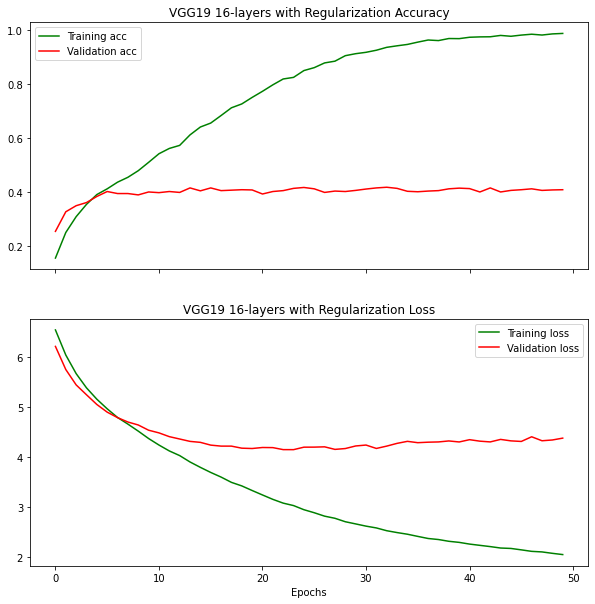

In [ ]:
# Plot model scores
visualize_scores(model4_hist, 'VGG19 16-layers with Regularization')
# model_scores = update_scores_df(model4, model4_hist, 'VGG19 16-layers with Regularization')

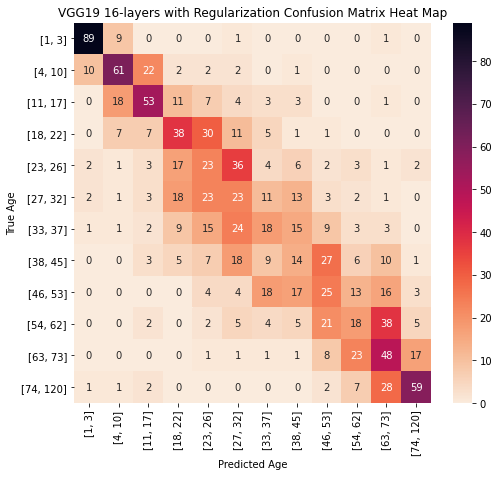

In [ ]:
plot_matrix(model4, "VGG19 16-layers with Regularization")

In [ ]:
model_scores

,Unnamed: 0,Model Name,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,0,CNN Baseline,1.383092,0.499583,1.789274,0.333333
1,1,VGG19 Baseline,1.171834,0.601042,1.590957,0.370833
2,2,VGG19 16-layers with Dropout(0.5),0.072023,0.986458,2.720024,0.408333
3,3,VGG19 16-layers with Regularization,2.052804,0.986979,4.529291,0.390833
4,4,VGG16,1.730817,0.535208,1.970884,0.446667
5,5,ResNet50 Layers with l2 Regularization,1.410144,0.994792,4.178020,0.351667
6,6,EfficientNet,0.066275,0.977500,5.137754,0.387500


There isn't any improvement from the previous model for the accuracy. The loss for the test data actually increased a lot. Therefore I will try a different pre-trained model as the base.

# VGG16

Next I will try out the VGG16 models which have less layers than the VGG19 model. This might potentially help with the overfitting problem.

I will make the last block in the base trainable. I will also add regulariztion to the dense layer and a dropout layer with a rate of 0.5

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Initialize Base
cnn_base_vgg16 = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))


# Define Model Architecture
model5 = models.Sequential()
model5.add(cnn_base_vgg16)
model5.add(layers.Flatten())
model5.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model5.add(layers.Dropout(0.5))

model5.add(layers.Dense(12, activation='softmax'))

# Freeze only some of the layers
for layer in cnn_base_vgg16.layers[0:15]:
    layer.trainable = False


# Check the layers
for layer in model5.layers:
    print(layer.name, layer.trainable)

print("\n")

for layer in cnn_base_vgg16.layers:
    print(layer.name, layer.trainable)

print("\n")

module_wrapper_1 True
flatten_1 True
dense_2 True
dropout_2 True
dense_3 True


input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True




In [ ]:
# Compile the model
model5.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

# Training the Model
model5_hist = model5.fit(train_batches,
                              epochs=50,
                              validation_data=valid_batches,
                              verbose=2
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
50/50 - 2645s - loss: 464.0919 - acc: 0.1431 - val_loss: 433.1581 - val_acc: 0.2625
Epoch 2/50
50/50 - 57s - loss: 404.9790 - acc: 0.2641 - val_loss: 376.2870 - val_acc: 0.3042
Epoch 3/50
50/50 - 56s - loss: 350.2455 - acc: 0.3165 - val_loss: 323.7987 - val_acc: 0.3383
Epoch 4/50
50/50 - 57s - loss: 299.8181 - acc: 0.3548 - val_loss: 275.5437 - val_acc: 0.3617
Epoch 5/50
50/50 - 55s - loss: 253.6008 - acc: 0.3742 - val_loss: 231.4772 - val_acc: 0.3750
Epoch 6/50
50/50 - 56s - loss: 211.5410 - acc: 0.3879 - val_loss: 191.5105 - val_acc: 0.3867
Epoch 7/50
50/50 - 56s - loss: 173.5513 - acc: 0.4114 - val_loss: 155.6241 - val_acc: 0.3942
Epoch 8/50
50/50 - 56s - loss: 139.6244 - acc: 0.4204 - val_loss: 123.7442 - val_acc: 0.3983
Epoch 9/50
50/50 - 56s - loss: 109.7075 - acc: 0.4313 - val_loss: 95.8666 - val_acc: 0.3992
Epoch 10/50
50/50 - 56s - loss: 83.7417 - acc: 0.4399 - val_loss: 71.9188 - val_acc: 0.3983
Epoch 11/50
50/50 - 56s - loss: 61.6890 - acc: 0.4485 - val_loss: 51.8

In [ ]:
# # Save the model
# model5.save('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model_5')
model5 = keras.models.load_model('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model_5')

38/38 [==============================] - 6s 141ms/step - loss: 1.9709 - acc: 0.4467


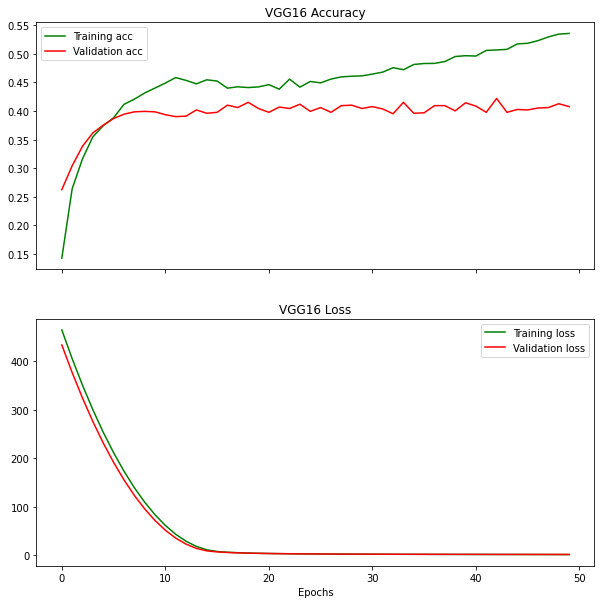

In [ ]:
# Plot model scores
visualize_scores(model5_hist, 'VGG16')
# model_scores = update_scores_df(model5, model5_hist, 'VGG16')

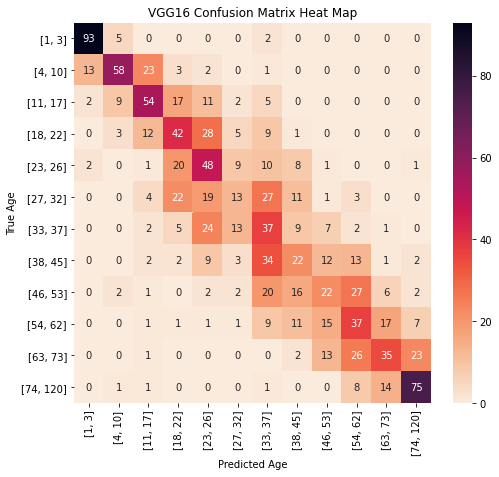

In [ ]:
plot_matrix(model5, "VGG16")

In [ ]:
model_scores

,Unnamed: 0,Model Name,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,0,CNN Baseline,1.383092,0.499583,1.789274,0.333333
1,1,VGG19 Baseline,1.171834,0.601042,1.590957,0.370833
2,2,VGG19 16-layers with Dropout(0.5),0.072023,0.986458,2.720024,0.408333
3,3,VGG19 16-layers with Regularization,2.052804,0.986979,4.529291,0.390833
4,4,VGG16,1.730817,0.535208,1.970884,0.446667
5,5,ResNet50 Layers with l2 Regularization,1.410144,0.994792,4.178020,0.351667
6,6,EfficientNet,0.066275,0.977500,5.137754,0.387500


Although an overfitting can still be seen for the accuarcy, the loss is pretty much the same for the training and validation data.




The accuracy for the test data improved to 0.447, and the loss decrased to 1.97. This is our best model so far but I will try out a few other pre-trained models as the base before choosing the final model.

# ResNet50 Layers with l2 Regularization

Next I will try out ResNet50 as the base.

I will try only partially freezing the base model and also using l2 regularization for the layers built on top of the base.

In [ ]:
# Initialize Base
ResNet50_base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

# Define Model Architecture
model6 = models.Sequential()
model6.add(ResNet50_base_model)
model6.add(layers.Flatten())
model6.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model6.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.005)))

# Add the Output Layer
model6.add(layers.Dense(12, activation='softmax'))


# Make the last block in ResNet50 untrainable
for layer in ResNet50_base_model.layers[:143]:
    layer.trainable = False

model6.build(input_shape=(None, 224, 224, 3))

# Check layers
for layer in model6.layers:
    print(layer.name, layer.trainable)

print('\n')

for layer in ResNet50_base_model.layers:
    print(layer.name, layer.trainable)



module_wrapper_5 True
flatten_5 True
dense_12 True
dense_13 True
dense_14 True


input_6 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_

In [ ]:
# Compile the model
model6.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

# Train the model
model6_hist = model6.fit(train_batches,
                              epochs=50,
                              validation_data=valid_batches,
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
32/32 [==============================] - 52s 1s/step - loss: 6.7008 - acc: 0.1382 - val_loss: 6.5399 - val_acc: 0.0833
Epoch 2/50
32/32 [==============================] - 45s 1s/step - loss: 5.7795 - acc: 0.3057 - val_loss: 6.2143 - val_acc: 0.0925
Epoch 3/50
32/32 [==============================] - 45s 1s/step - loss: 5.2938 - acc: 0.3735 - val_loss: 5.9573 - val_acc: 0.0992
Epoch 4/50
32/32 [==============================] - 45s 1s/step - loss: 4.9076 - acc: 0.4279 - val_loss: 5.7843 - val_acc: 0.1008
Epoch 5/50
32/32 [==============================] - 45s 1s/step - loss: 4.6034 - acc: 0.4813 - val_loss: 5.6123 - val_acc: 0.0900
Epoch 6/50
32/32 [==============================] - 46s 1s/step - loss: 4.3489 - acc: 0.5166 - val_loss: 5.5218 - val_acc: 0.1108
Epoch 7/50
32/32 [==============================] - 45s 1s/step - loss: 4.0905 - acc: 0.5654 - val_loss: 5.4425 - val_acc: 0.0983
Epoch 8/50
32/32 [==============================] - 45s 1s/step - loss: 3.8794 - acc: 0.60

38/38 [==============================] - 7s 115ms/step - loss: 4.1780 - acc: 0.3517


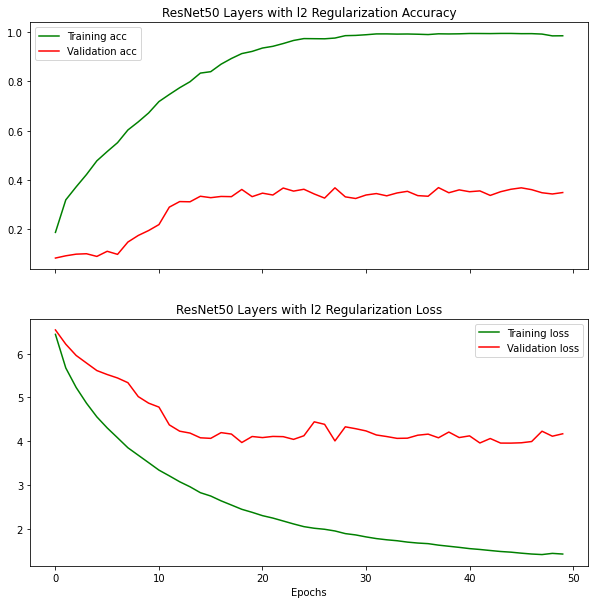

In [ ]:
visualize_scores(model6_hist, 'ResNet50 Layers with l2 Regularization')
# model_scores = update_scores_df(model6, model6_hist, 'ResNet50 Layers with l2 Regularization')

In [ ]:
# Save the model
# model6.save('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/ResNet50')
model6 = keras.models.load_model('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/ResNet50')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/ResNet50/assets


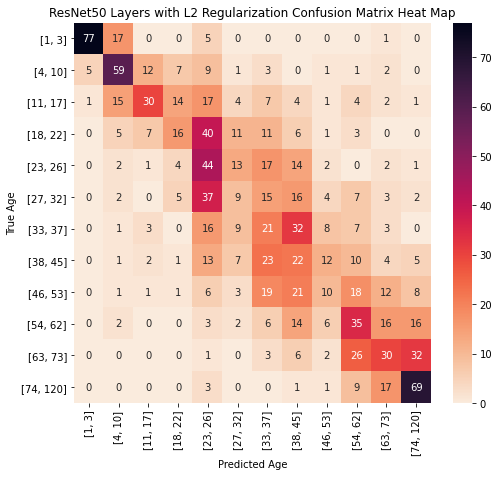

In [ ]:
plot_matrix(model6, "ResNet50 Layers with L2 Regularization")

In [ ]:
model_scores

,Unnamed: 0,Model Name,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,0,CNN Baseline,1.383092,0.499583,1.789274,0.333333
1,1,VGG19 Baseline,1.171834,0.601042,1.590957,0.370833
2,2,VGG19 16-layers with Dropout(0.5),0.072023,0.986458,2.720024,0.408333
3,3,VGG19 16-layers with Regularization,2.052804,0.986979,4.529291,0.390833
4,4,VGG16,1.730817,0.535208,1.970884,0.446667
5,5,ResNet50 Layers with l2 Regularization,1.410144,0.994792,4.178020,0.351667
6,6,EfficientNet,0.066275,0.977500,5.137754,0.387500


The massive overfitting problem return when using ResNet50 as the base. The accuarcy for the test data is much lower than the previous model. The loss is also bigger. The model seems to struggle with age bins in the middle similar to our baseline model.

This model doesn't perform much better than our baseline CNN model. Therefore I will try another pre-trained model as the base.

# EfficientNet

This time I will try using EfficientNet which is from google as the base. First I need to install the necessary files.

In [ ]:
!pip install -U efficientnet


     |████████████████████████████████| 50 kB 7.8 MB/s 


In [ ]:
import efficientnet.keras as efn


# Initialize Base
EffNet_base = tf.keras.applications.EfficientNetB0(input_shape = (224, 224, 3), include_top = False)


# Define Model Architecture
model7 = models.Sequential()
model7.add(EffNet_base)
# model7.add(layers.Flatten())
model7.add(layers.GlobalAveragePooling2D())
# model7.add(layers.BatchNormalization())
model7.add(layers.Dropout(0.3))


# Add the Output Layer
model7.add(layers.Dense(12, activation='softmax'))

# EffNet_base.trainable = False
# Make the last two blocks trainable
for layer in EffNet_base.layers[:162]:
       layer.trainable = False

# Check layers
for layer in model7.layers:
    print(layer.name, layer.trainable)

print('\n')

for layer in EffNet_base.layers:
    print(layer.name, layer.trainable)

print('\n')


16711680/16705208 [==============================] - 0s 0us/step
module_wrapper_6 True
global_average_pooling2d True
dropout_4 True
dense_15 True


input_7 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
bloc

In [ ]:
train_batches_Eff = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(directory=train_dir, target_size=(224,224), batch_size=(300), class_mode='categorical')
valid_batches_Eff = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(directory=validation_dir, target_size=(224,224), batch_size=(100), class_mode='categorical')
test_batches_Eff = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(directory=test_dir, target_size=(224,224), batch_size=(1200), class_mode='categorical', shuffle = False)
test_images_Eff, test_labels_Eff = next(test_batches_Eff)

Found 9600 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.


In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(lr=1e-2)

model7.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

# Train the model
model7_hist = model7.fit(train_batches_Eff,
                        epochs=50,
                        validation_data= valid_batches_Eff)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
32/32 [==============================] - 48s 1s/step - loss: 2.0133 - acc: 0.2701 - val_loss: 655.2690 - val_acc: 0.0850
Epoch 2/50
32/32 [==============================] - 33s 1s/step - loss: 1.3798 - acc: 0.4322 - val_loss: 14.5300 - val_acc: 0.2167
Epoch 3/50
32/32 [==============================] - 33s 1s/step - loss: 1.2399 - acc: 0.4912 - val_loss: 4.4978 - val_acc: 0.3125
Epoch 4/50
32/32 [==============================] - 33s 1s/step - loss: 1.1318 - acc: 0.5278 - val_loss: 11.5489 - val_acc: 0.1783
Epoch 5/50
32/32 [==============================] - 33s 1s/step - loss: 1.0410 - acc: 0.5705 - val_loss: 26.2690 - val_acc: 0.1325
Epoch 6/50
32/32 [==============================] - 33s 1s/step - loss: 0.9611 - acc: 0.6105 - val_loss: 15.9716 - val_acc: 0.1567
Epoch 7/50
32/32 [==============================] - 33s 1s/step - loss: 0.8414 - acc: 0.6639 - val_loss: 6.0116 - val_acc: 0.2608
Epoch 8/50
32/32 [==============================] - 35s 1s/step - loss: 0.7491 - acc

38/38 [==============================] - 3s 69ms/step - loss: 5.1378 - acc: 0.3875


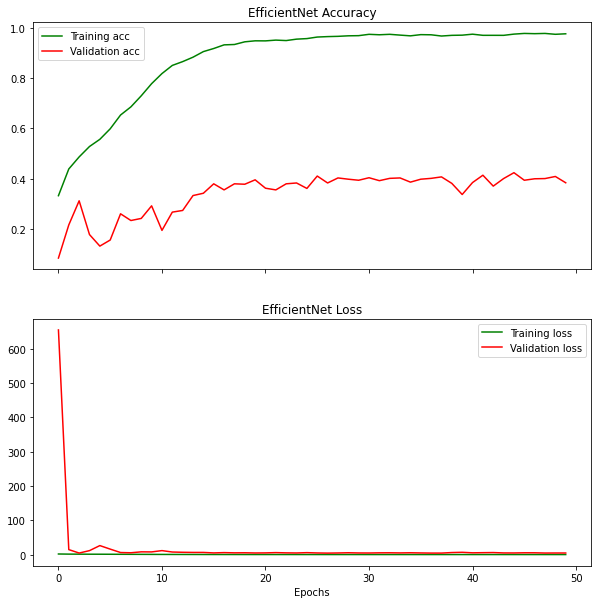

In [ ]:
visualize_scores(model7_hist, "EfficientNet")
# model_scores = update_scores_df(model7, model7_hist, 'EfficientNet', test_img=test_images_Eff, test_lab=test_labels_Eff)

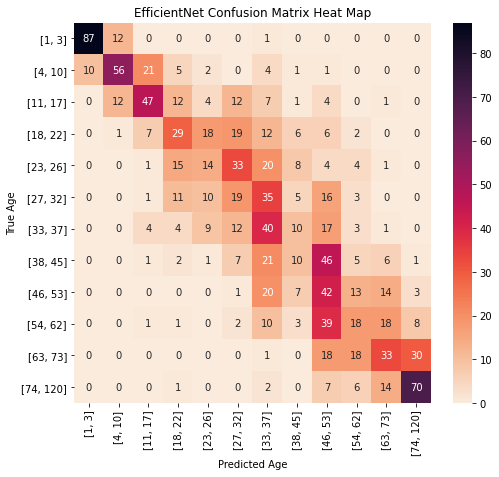

In [ ]:
plot_matrix(model7, "EfficientNet", test_label= test_labels_Eff, test_img= test_images_Eff)

In [ ]:
# model7.save('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/EfficientNet')
model7 = keras.models.load_model('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/EfficientNet')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/EfficientNet/assets


In [ ]:
model_scores

,Unnamed: 0,Model Name,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,0,CNN Baseline,1.383092,0.499583,1.789274,0.333333
1,1,VGG19 Baseline,1.171834,0.601042,1.590957,0.370833
2,2,VGG19 16-layers with Dropout(0.5),0.072023,0.986458,2.720024,0.408333
3,3,VGG19 16-layers with Regularization,2.052804,0.986979,4.529291,0.390833
4,4,VGG16,1.730817,0.535208,1.970884,0.446667
5,5,ResNet50 Layers with l2 Regularization,1.410144,0.994792,4.178020,0.351667
6,6,EfficientNet,0.066275,0.977500,5.137754,0.387500


The model again does a great job on the training data but struggles with the validation and test data. The loss for training data is best we have gotten yet but for the test data it is the worst one. There is huge overfitting problem for the last two models.

# Choosing a Model

Now I will compare the metrics of all the models that I built to choose one of them.

In [ ]:
model_scores

,Unnamed: 0,Model Name,Training Loss,Training Accuracy,Testing Loss,Testing Accuracy
0,0,CNN Baseline,1.383092,0.499583,1.789274,0.333333
1,1,VGG19 Baseline,1.171834,0.601042,1.590957,0.370833
2,2,VGG19 16-layers with Dropout(0.5),0.072023,0.986458,2.720024,0.408333
3,3,VGG19 16-layers with Regularization,2.052804,0.986979,4.529291,0.390833
4,4,VGG16,1.730817,0.535208,1.970884,0.446667
5,5,ResNet50 Layers with l2 Regularization,1.410144,0.994792,4.178020,0.351667
6,6,EfficientNet,0.066275,0.977500,5.137754,0.387500


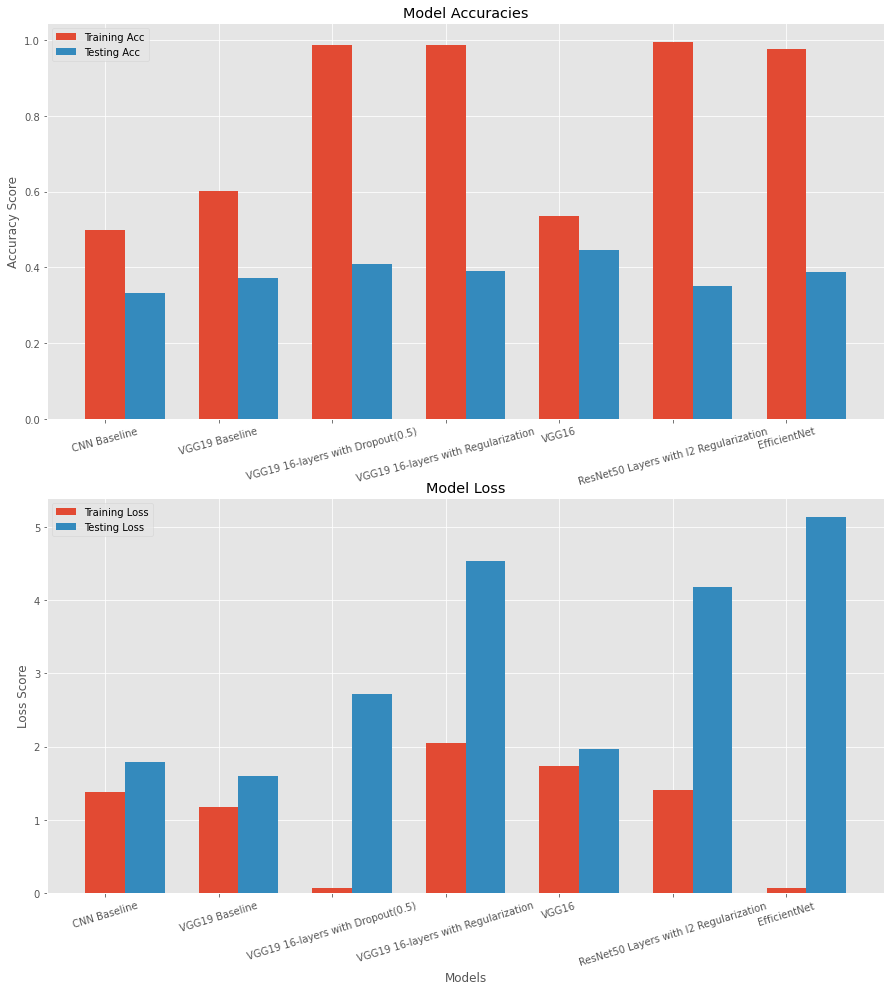

In [ ]:
#Plot out the results

x_indexes = np.arange(len(model_scores['Model Name']))
plt.style.use("ggplot")
width=0.35

fig, ax = plt.subplots(2, 1, figsize=(15,16))

ax[0].bar(x_indexes, model_scores['Training Accuracy'], width=width, label="Training Acc")
ax[0].bar(x_indexes + width, model_scores['Testing Accuracy'], width=width, label="Testing Acc")
ax[1].bar(x_indexes, model_scores['Training Loss'], width=width, label="Training Loss")
ax[1].bar(x_indexes + width, model_scores['Testing Loss'], width=width, label="Testing Loss")




plt.xticks(ticks = x_indexes, labels=model_scores['Model Name'] )
ax[0].legend()
ax[0].set_xticks(x_indexes)
ax[0].set_xticklabels(model_scores['Model Name'], rotation=15)
ax[0].set_title("Model Accuracies")
ax[0].set_ylabel("Accuracy Score")

ax[1].set_title("Model Loss")
ax[1].set_xlabel("Models")
ax[1].set_ylabel("Loss Score")
ax[1].legend()
ax[1].set_xticks(x_indexes)
ax[1].set_xticklabels(model_scores['Model Name'], rotation=17)


# plt.tight_layout()
plt.show()

It is apparent that a lot of the models suffer from overfitting.The VGG19 models, ResNet50 and Efficient Net all have way higher accuracies and lower loss on the training images than they do on the testing images. It seems that the models with more layers have a bigger overfitting problem and perform worse on the test data.


 The highest accuracy on the testing dataset was achieved by the VGG16 model. This model also have the second lowest loss, which was still decreasing when the training was stopped. Therefore I will choose the model that use VGG16 as the base for our final predictor.

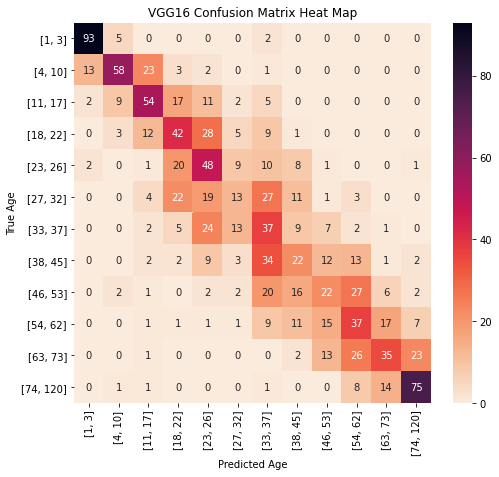

In [ ]:
plot_matrix(model5, "VGG16")

Our predictor did a great job doing its job. Aside from a few outliers where age bins far aways from the true bin are predicted, most predictions fall just within a 4 bin range from the true age. It seem the model had the most trouble with ages around 27-38. It does a great job at predicting infants, childrens and teens. It also did a great job at predicting ages over 74.

# Predictor

Our predictor will either take in an array or a url link. If it is an array, it has to be already scaled by 1/255 and in the shape of (224, 224, 3). Since the test images from our datasets are already scaled, they do not need further preparation.


As for the url link, if jpg or png is provided to the predictor, the image will be downloaded, scaled and the predictions will be returned. A filename argument can be added to save the image by a specific name and have it not be overwrited in the future.

In [ ]:
# Load in the model and compile it
model5 = keras.models.load_model('/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/saved_models/CNN_Model_5')
model5.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])


def age_predictor(url = None, array = None, filename = "test_img", model = model5):
    if url is not None:

      dir = "/drive/MyDrive/Colab_Notebooks/CNN_Age_Recognition/test_images/" + filename
      # download the image from the url and save
      os.system("curl -s {} -o {}".format(url, dir))

      img = image.load_img(dir, target_size=(224, 224))

      x = image.img_to_array(img)

      plt.imshow(img)
      plt.axis('off')

      x = np.expand_dims(x, axis=0)
      images = np.vstack([x])/255
      prediction = model5.predict(images)
      
      # use argsort() to sort the indexes of the breeds
      # print the breed names and percentages of top 5 breeds with highest probabilities 
      for idx in prediction.argsort()[0][::-1][:5]:
          print("{:.2f}%".format(prediction[0][idx]*100), "\t", label_maps_rev[idx])

    elif array is not None:

        plt.imshow(array)
        plt.axis('off')
        
        x = np.expand_dims(array, axis=0)

        images = np.vstack([x])
        # images = images/255
        
        prediction = model.predict(images)
        for idx in prediction.argsort()[0][::-1][:5]:
          print("{:.2f}%".format(prediction[0][idx]*100), "\t", label_maps_rev[idx])



    else:
      print("Invalid Input")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


99.91% 	 [63, 73]
0.07% 	 [74, 120]
0.01% 	 [46, 53]
0.01% 	 [54, 62]
0.00% 	 [04, 10]
Real Age Bracket : [54, 62]


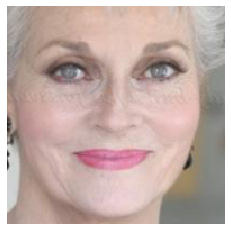

In [ ]:
age_predictor(array=test_images[984])
print("Real Age Bracket : " + label_maps_rev[test_labels[984].argmax()])

Our predictor is off one bin for this prediction.

100.00% 	 [01, 03]
0.00% 	 [04, 10]
0.00% 	 [18, 22]
0.00% 	 [46, 53]
0.00% 	 [11, 17]
Real Age Bracket : [01, 03]


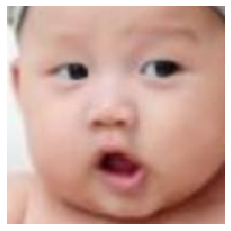

In [ ]:
age_predictor(array=test_images[22])
print("Real Age Bracket : " + label_maps_rev[test_labels[22].argmax()])

As expected our predictor excels at predicting ages for infants.

59.23% 	 [04, 10]
40.74% 	 [11, 17]
0.03% 	 [01, 03]
0.00% 	 [18, 22]
0.00% 	 [38, 45]
Real Age Bracket : [11, 17]


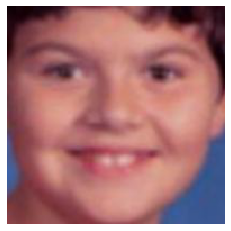

In [ ]:
age_predictor(array=test_images[200])
print("Real Age Bracket : " + label_maps_rev[test_labels[200].argmax()])

This time our predictor is 59% confident in its prediction that is off 1 bin, and the correct bin got 40% propability.

68.20% 	 [46, 53]
11.71% 	 [38, 45]
9.66% 	 [54, 62]
7.27% 	 [33, 37]
2.03% 	 [27, 32]
Real Age Bracket : [54, 62]


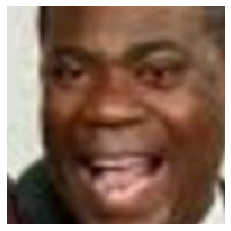

In [ ]:
rand_i = random.randint(0, 1199)
age_predictor(array=test_images[rand_i])
print("Real Age Bracket : " + label_maps_rev[test_labels[rand_i].argmax()])

### Predicting using an URL
Next I will pass in several url images and see how the model perform.

First it correctly predicted Sir Ian Mckellen age as being over 74 with an certainess of 99.98 percent.

99.98% 	 [74, 120]
0.01% 	 [63, 73]
0.00% 	 [04, 10]
0.00% 	 [54, 62]
0.00% 	 [33, 37]


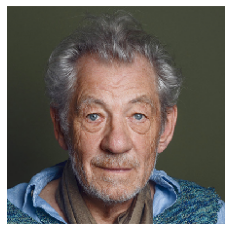

In [ ]:
age_predictor(url = "https://pbs.twimg.com/profile_images/1181620569474646016/3kpB7bLR.png")

99.47% 	 [74, 120]
0.51% 	 [01, 03]
0.01% 	 [63, 73]
0.00% 	 [04, 10]
0.00% 	 [27, 32]


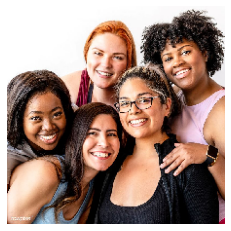

In [ ]:
age_predictor(url = "https://dz9yg0snnohlc.cloudfront.net/cro-how-to-get-people-to-accept-me-for-who-i-am-3.jpg", filename="testimg2")

Since our predictor is trained solely on images of single cropped faces, it doesn't perform well when images of multiple people are passed in.

74.16% 	 [46, 53]
19.99% 	 [63, 73]
4.93% 	 [01, 03]
0.38% 	 [74, 120]
0.33% 	 [04, 10]


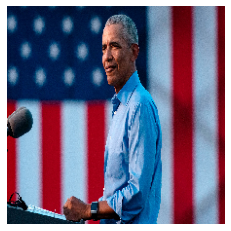

In [ ]:
age_predictor(url = "https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F20%2F2021%2F04%2F23%2Fbarack-obama-3.jpg", filename="testimg3")

86.50% 	 [11, 17]
5.24% 	 [18, 22]
3.84% 	 [04, 10]
2.78% 	 [33, 37]
1.13% 	 [46, 53]


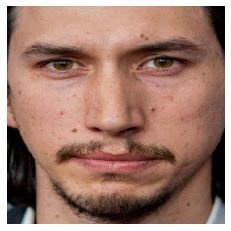

In [ ]:
age_predictor(url = "https://i.pinimg.com/originals/04/13/c9/0413c98669ae561f50bc74e6368c76d9.jpg", filename="testimg4")

98.30% 	 [74, 120]
1.69% 	 [63, 73]
0.00% 	 [54, 62]
0.00% 	 [04, 10]
0.00% 	 [46, 53]


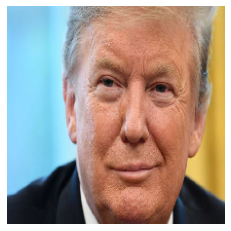

In [ ]:
age_predictor(url = "https://www.abc.net.au/news/image/10844460-3x2-940x627.jpg", filename="testimg5")

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


99.53% 	 [33, 37]
0.22% 	 [63, 73]
0.09% 	 [01, 03]
0.09% 	 [46, 53]
0.06% 	 [18, 22]


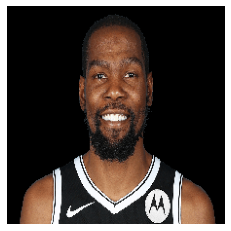

In [ ]:
age_predictor(url = "https://cdn.nba.com/headshots/nba/latest/1040x760/201142.png", filename="testimg6")

# Improvements

Our model performs very well on test data but struggles a little bit with faces of celebrities. This can be expected since celebrities generally look younger.

Improvements to be made -

  - Train on larger datasets
  - Change the sizes of age bins
  - Use higher resolution images
  - Try out other transfer learning models
  - Train Longer